In [1]:
import numpy as np
import pandas as pd

C:\Users\Hp\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
C:\Users\Hp\anaconda3\lib\site-packages\pandas\core\arrays\masked.py:61: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
train_df = pd.read_csv("../data/data.csv")

In [3]:
train_copy = train_df.copy()

# EDA and Data Preprocessing

In [4]:
#dropping "area_mean" and "perimeter_mean" because they are highly correlated with "radius_mean"
train_copy = train_copy.drop("Unnamed: 32", axis = True)
train_copy = train_copy.drop("id", axis = True)
train_copy = train_copy.drop("area_mean", axis = True)
train_copy = train_copy.drop("perimeter_mean", axis = True)

In [5]:
#preparing X and Y
X = train_copy.drop("diagnosis", axis = True)
Y = train_copy["diagnosis"]

In [6]:
#we see "area_mean" and "perimeter_mean" are highly correlated with "radius_mean"
cor_matrix = X.corr()
print(cor_matrix)

                         radius_mean  texture_mean  smoothness_mean  \
radius_mean                 1.000000      0.323782         0.170581   
texture_mean                0.323782      1.000000        -0.023389   
smoothness_mean             0.170581     -0.023389         1.000000   
compactness_mean            0.506124      0.236702         0.659123   
concavity_mean              0.676764      0.302418         0.521984   
concave points_mean         0.822529      0.293464         0.553695   
symmetry_mean               0.147741      0.071401         0.557775   
fractal_dimension_mean     -0.311631     -0.076437         0.584792   
radius_se                   0.679090      0.275869         0.301467   
texture_se                 -0.097317      0.386358         0.068406   
perimeter_se                0.674172      0.281673         0.296092   
area_se                     0.735864      0.259845         0.246552   
smoothness_se              -0.222600      0.006614         0.332375   
compac

In [7]:
# preparing training and validation sets
from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(X,Y, test_size = 0.2, random_state = 42)

In [8]:
#we scaling data for our models
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_val = scaler.transform(x_val)

In [9]:
# we do label encoding for xgboost
from sklearn.preprocessing import LabelEncoder

label = LabelEncoder()
y_train = label.fit_transform(y_train) 
y_val = label.transform(y_val) 

# Training Models and Visualizations

In [10]:
# firstly we used Logistic Regression 
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

log_model = LogisticRegression(random_state = 42)

log_model.fit(x_train, y_train)
log_predicts = log_model.predict(x_val)
log_score = accuracy_score(y_val, log_predicts)

print(f"Validation Score: {log_score * 100:.2f}%")

Validation Score: 98.25%


In [11]:
# The baseline results look promising.
from sklearn.metrics import classification_report

print(classification_report(y_val, log_predicts))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99        71
           1       0.98      0.98      0.98        43

    accuracy                           0.98       114
   macro avg       0.98      0.98      0.98       114
weighted avg       0.98      0.98      0.98       114



In [12]:
#secondly we used Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier

forest_model = RandomForestClassifier(random_state = 42,n_estimators = 100, max_depth = 5)
forest_model.fit(x_train, y_train)
forest_predicts = forest_model.predict(x_val)
forest_score = accuracy_score(y_val, forest_predicts)

print(f"Random Forest Scores: {forest_score * 100:.2f}%")

Random Forest Scores: 96.49%


In [13]:
# The results were lower than expected, so we switched to the XGBoost Classifier.
print(classification_report(y_val, forest_predicts))

              precision    recall  f1-score   support

           0       0.96      0.99      0.97        71
           1       0.98      0.93      0.95        43

    accuracy                           0.96       114
   macro avg       0.97      0.96      0.96       114
weighted avg       0.97      0.96      0.96       114



In [14]:
# Hyperparameter tuning using RandomizedSearchCV
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV

param_dist = {
    
    'n_estimators': [100, 200, 300, 400, 500, 700, 1000],
    
    'learning_rate': [0.01, 0.02, 0.03, 0.05, 0.1, 0.15],
    
    'max_depth': [5, 7, 10, 15],

    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
    
    'reg_alpha': [0, 0.1, 0.5, 1],
    'reg_lambda': [0, 0.1, 0.5, 1]
}

xgb_model2 = xgb.XGBClassifier(random_state = 42)
rand_search = RandomizedSearchCV(
    estimator = xgb_model2,
    param_distributions = param_dist,
    n_iter = 100,
    scoring = "accuracy",
    n_jobs = -2,
    cv = 5
)

rand_search.fit(x_train,y_train)

print(f"The best score: {rand_search.best_score_ * 100:.2f}%")
print("Best parameters:")
print(rand_search.best_params_)


The best score: 97.80%
Best parameters:
{'subsample': 0.6, 'reg_lambda': 1, 'reg_alpha': 0, 'n_estimators': 1000, 'max_depth': 10, 'learning_rate': 0.1, 'colsample_bytree': 0.8}


In [15]:
# Training the XGBoost model with the best parameters found

xgb_model = xgb.XGBClassifier(subsample = 0.6, reg_lambda = 0.5, reg_alpha =  0, n_estimators =  700, max_depth = 15, learning_rate =  0.03, colsample_bytree =  0.9)
xgb_model.fit(x_train,y_train)
xgb_predicts = xgb_model.predict(x_val)
xgb_scores = accuracy_score(y_val, xgb_predicts)

print(f"xgboost scores : {xgb_scores * 100:.2f}")

importances = xgb_model.feature_importances_
feature_names = X.columns

#I ranked the feature importance
feature_importance_df = pd.DataFrame({
    "Feature" : feature_names,
    "Importance" : importances
})

feature_importance_df = feature_importance_df.sort_values(
    by='Importance', 
    ascending=False
).reset_index(drop=True)

print("--- XGBoost Feature Importance Ranking (Gain) ---")
print(feature_importance_df.head(15))

xgboost scores : 97.37
--- XGBoost Feature Importance Ranking (Gain) ---
                   Feature  Importance
0      concave points_mean    0.190804
1     concave points_worst    0.174845
2          perimeter_worst    0.145318
3               area_worst    0.092828
4             radius_worst    0.081345
5          concavity_worst    0.030701
6                  area_se    0.023727
7            texture_worst    0.023163
8        compactness_worst    0.020202
9             texture_mean    0.019582
10               radius_se    0.019128
11            perimeter_se    0.018046
12            concavity_se    0.016049
13          concavity_mean    0.013785
14  fractal_dimension_mean    0.013372


In [16]:
print(classification_report(y_val, xgb_predicts))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98        71
           1       0.98      0.95      0.96        43

    accuracy                           0.97       114
   macro avg       0.97      0.97      0.97       114
weighted avg       0.97      0.97      0.97       114



Optimal Threshold : 0.6679
TPR (Recall): 0.9535
FPR (False Alarm): 0.0141


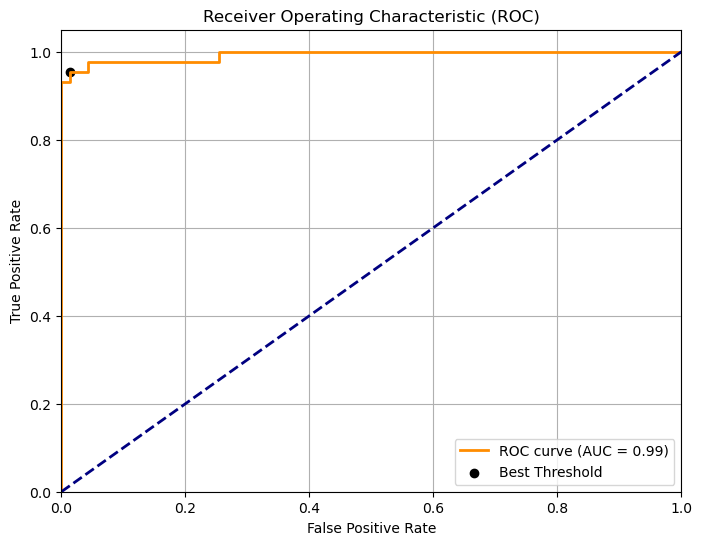

In [18]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# get being canser probs
y_pred_proba = xgb_model.predict_proba(x_val)[:, 1]

# find tpr,fpr and thresholds
fpr, tpr, thresholds = roc_curve(y_val, y_pred_proba)
roc_auc = auc(fpr, tpr)

# find elbow point
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]

print(f"Optimal Threshold : {optimal_threshold:.4f}")
print(f"TPR (Recall): {tpr[optimal_idx]:.4f}")
print(f"FPR (False Alarm): {fpr[optimal_idx]:.4f}")

# tpr and fpr scatter
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--') 
plt.scatter(fpr[optimal_idx], tpr[optimal_idx], marker='o', color='black', label='Best Threshold')# Noktayı işaretle

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()



In [ ]:
# new metrics with best threshold
y_pred_new_threshold = (y_pred_proba > optimal_threshold).astype(int)

print(classification_report(y_val, y_pred_new_threshold))

:lowest score among cancer patients (new threshold) 0.0079
              precision    recall  f1-score   support

           0       1.00      0.75      0.85        71
           1       0.70      1.00      0.83        43

    accuracy                           0.84       114
   macro avg       0.85      0.87      0.84       114
weighted avg       0.89      0.84      0.84       114



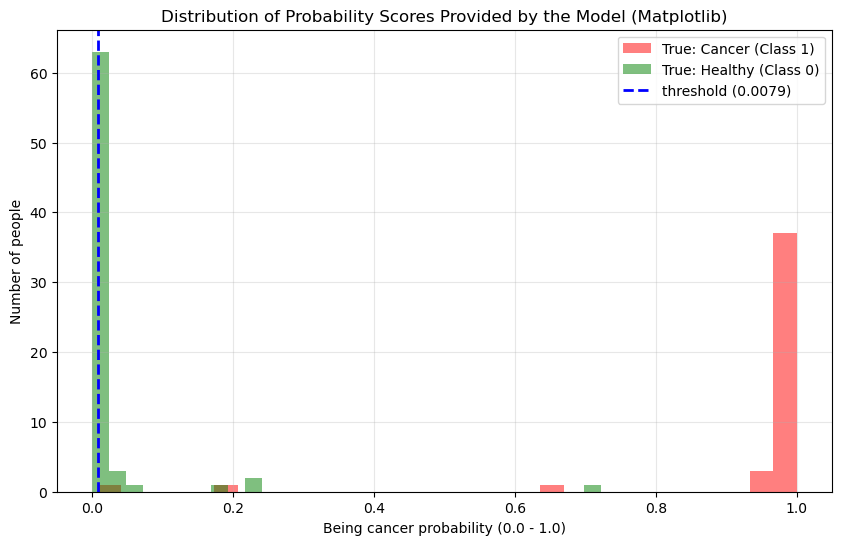

In [19]:
import seaborn as sns
from sklearn.metrics import classification_report

# get real having cancer probs
actual_cancer_probs = y_pred_proba[np.array(y_val) == 1]

# Find the lowest score among cancer patients.
safe_threshold = np.min(actual_cancer_probs)

print(f"Lowest predicted probability for an actual cancer patient (New Threshold): {safe_threshold:.4f}")

# new report
y_pred_safe = (y_pred_proba >= safe_threshold).astype(int)
print(classification_report(y_val, y_pred_safe))

y_val_array = np.array(y_val)

# Visualize
plt.figure(figsize=(10, 6))

# cancer patients distrubitions
plt.hist(y_pred_proba[y_val_array == 1], 
         bins=30, 
         alpha=0.5, 
         color='red', 
         label='True: Cancer (Class 1)')

# healty peoples distrubitions
plt.hist(y_pred_proba[y_val_array == 0], 
         bins=30, 
         alpha=0.5, 
         color='green', 
         label='True: Healthy (Class 0)')

# threshold line
plt.axvline(safe_threshold, color='blue', linestyle='--', linewidth=2, label=f'threshold ({safe_threshold:.4f})')

plt.title('Distribution of Probability Scores Provided by the Model (Matplotlib)')
plt.xlabel('Being cancer probability (0.0 - 1.0)')
plt.ylabel('Number of people')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()



# PCA

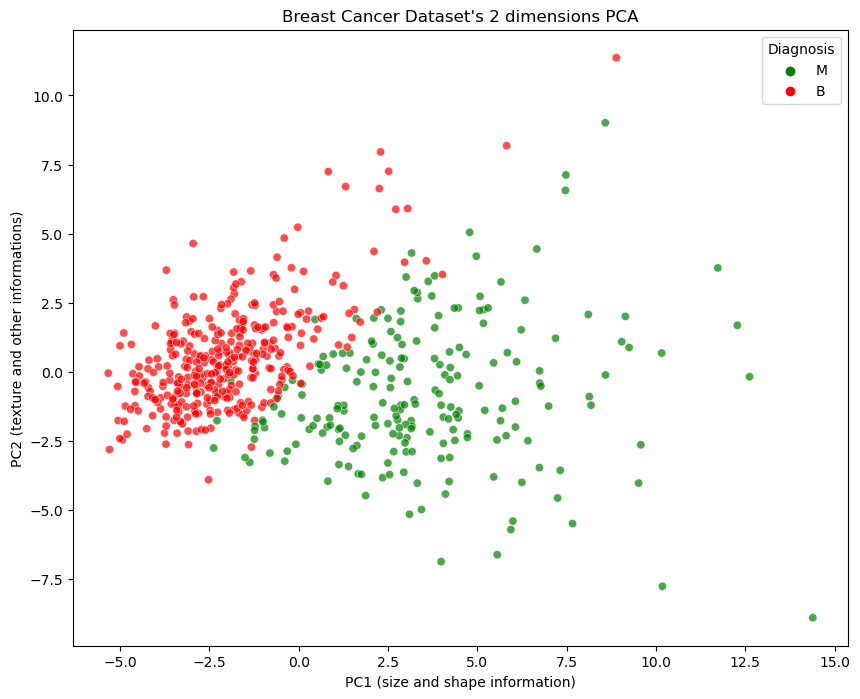

These two components explain %61.04 of the information


In [20]:
from sklearn.decomposition import PCA

X_for_pca = X.copy()
X_for_pca = scaler.fit_transform(X_for_pca)

# implement PCA (30 -> 2)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_for_pca)

# Make DataFrame for visualization
df_pca = pd.DataFrame(data=X_pca, columns=['Principal Component 1', 'Principal Component 2'])
df_pca['Diagnosis'] = Y 


plt.figure(figsize=(10, 8))
sns.scatterplot(
    x='Principal Component 1', 
    y='Principal Component 2', 
    hue='Diagnosis', 
    data=df_pca, 
    palette=['green', 'red'], # 0: Green (Healthy), 1: Red (Cancer)
    alpha=0.7
)
plt.title("Breast Cancer Dataset's 2 dimensions PCA")
plt.xlabel('PC1 (size and shape information)')
plt.ylabel('PC2 (texture and other informations)')
plt.show()

# Explained info ratio
print(f"These two components explain {pca.explained_variance_ratio_.sum()*100:.2f}% of the information")